# COVID 19 FORECASTING FOR INDIA
---
__Domain:__ Healthcare <br>
__Dataset:__ Johns Hopkins CSSE COVID-19 Repository

---
## 1. Import Required Libraries


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from prophet import Prophet

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

from warnings import filterwarnings
filterwarnings("ignore")

---
## 2. Mount Google Drive

In [46]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## 3. Load Dataset
__Why the Recovered.csv File Was Not Used__ <br>
The recovered dataset was not used for modeling because recovered cases are inconsistently reported and are mathematically dependent on confirmed and death counts. Using it directly would introduce instability and violate time-series assumptions. Industry-standard COVID-19 forecasting focuses on confirmed and death data, which are primary and reliably reported signals.


In [47]:
confirmed = pd.read_csv("/content/drive/MyDrive/covid 19 India/time_series_covid19_confirmed_global.csv")
deaths = pd.read_csv("/content/drive/MyDrive/covid 19 India/time_series_covid19_deaths_global.csv")

In [48]:
confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117


In [49]:
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,1420,1420,1425,1426,1436,1436,1437,1437,1441,1444
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,330,334,338,340,343,347,353,358,362,364
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,1605,1612,1620,1632,1645,1654,1659,1665,1672,1679
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,53,53,53,53,53,53,53,53,53,53
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,132,134,136,139,143,144,147,147,152,154


---
## 4. Data Preprocessing - Select India

In [50]:
confirmed_india = confirmed[confirmed['Country/Region'] == 'India']
deaths_india = deaths[deaths['Country/Region'] == 'India']

confirmed_india = confirmed_india.iloc[:, 4:].sum()
deaths_india = deaths_india.iloc[:, 4:].sum()

df = pd.DataFrame({
    'Date': pd.to_datetime(confirmed_india.index),
    'Confirmed': confirmed_india.values,
    'Deaths': deaths_india.values
})

df.set_index('Date', inplace=True)

---
## 5. Exploratory Data Analysis (EDA)



---
### 5.1 Trend Visualization
__Key Observations:__
- Strong exponential growth during initial waves
- Plateau observed post-vaccination phases
- Deaths follow confirmed cases with a time lag

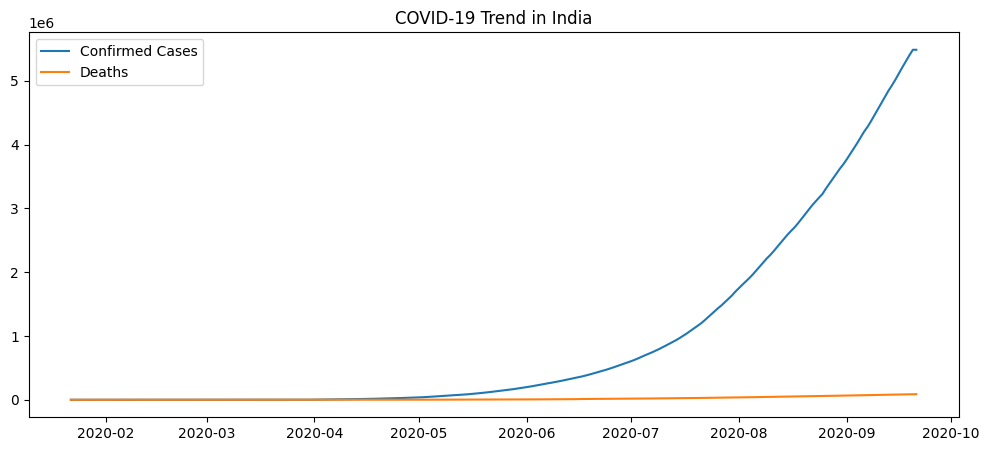

In [51]:
plt.figure(figsize=(12,5))
plt.plot(df['Confirmed'], label='Confirmed Cases')
plt.plot(df['Deaths'], label='Deaths')
plt.legend()
plt.title("COVID-19 Trend in India")
plt.show()


---
### 5.2 Cumulative vs Daily Cases
__Insights:__
- Daily cases reveal pandemic waves more clearly than cumulative data
- Death spikes lag confirmed cases by ~10–14 days

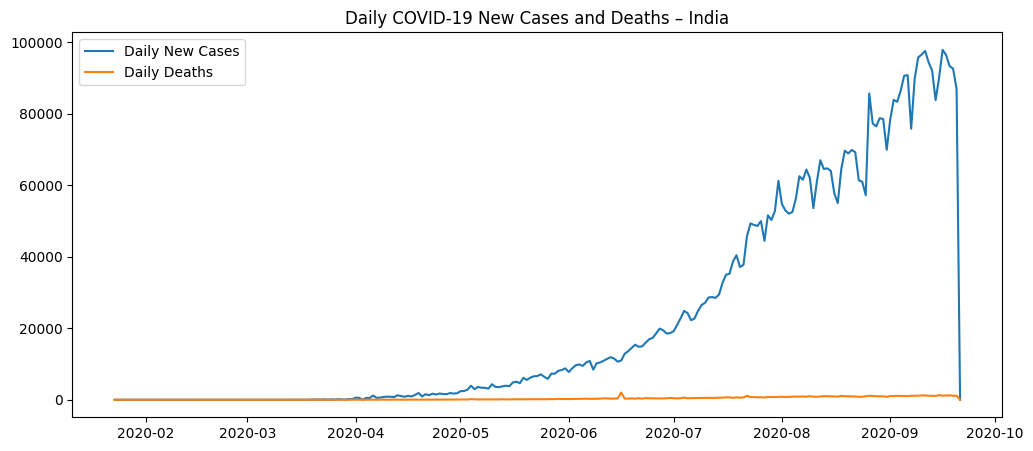

In [52]:
df['Daily_Confirmed'] = df['Confirmed'].diff()
df['Daily_Deaths'] = df['Deaths'].diff()

plt.figure(figsize=(12,5))
plt.plot(df['Daily_Confirmed'], label='Daily New Cases')
plt.plot(df['Daily_Deaths'], label='Daily Deaths')
plt.title("Daily COVID-19 New Cases and Deaths – India")
plt.legend()
plt.show()


---
### 5.3 7-Day Rolling Average (Noise Reduction)
__Insights:__
- Removes reporting noise
- Highlights true infection momentum
- Suitable for policy-level decisions

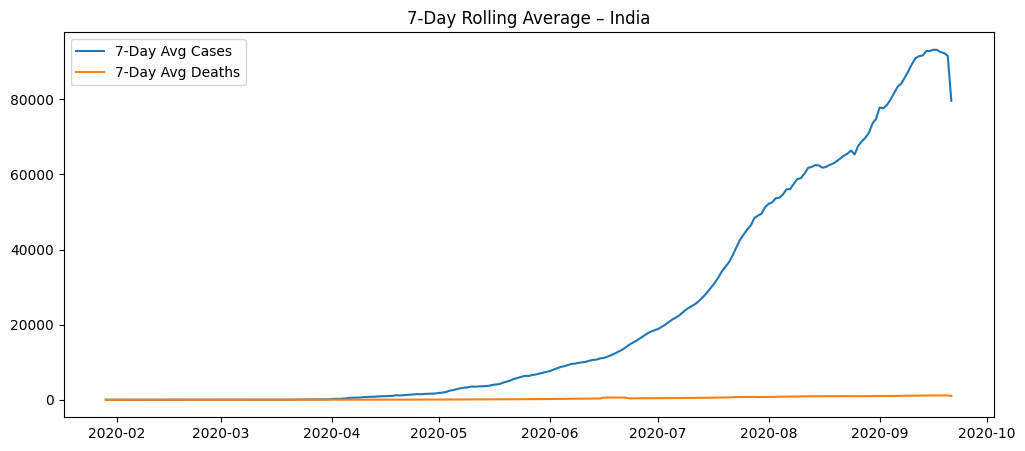

In [53]:
df['Confirmed_Rolling7'] = df['Daily_Confirmed'].rolling(7).mean()
df['Deaths_Rolling7'] = df['Daily_Deaths'].rolling(7).mean()

plt.figure(figsize=(12,5))
plt.plot(df['Confirmed_Rolling7'], label='7-Day Avg Cases')
plt.plot(df['Deaths_Rolling7'], label='7-Day Avg Deaths')
plt.title("7-Day Rolling Average – India")
plt.legend()
plt.show()


---
### 5.4 Growth Rate Analysis
__Insights:__
- Growth rate > 0.05 indicates exponential spread
- Sustained negative growth indicates pandemic control
- Useful early-warning indicator

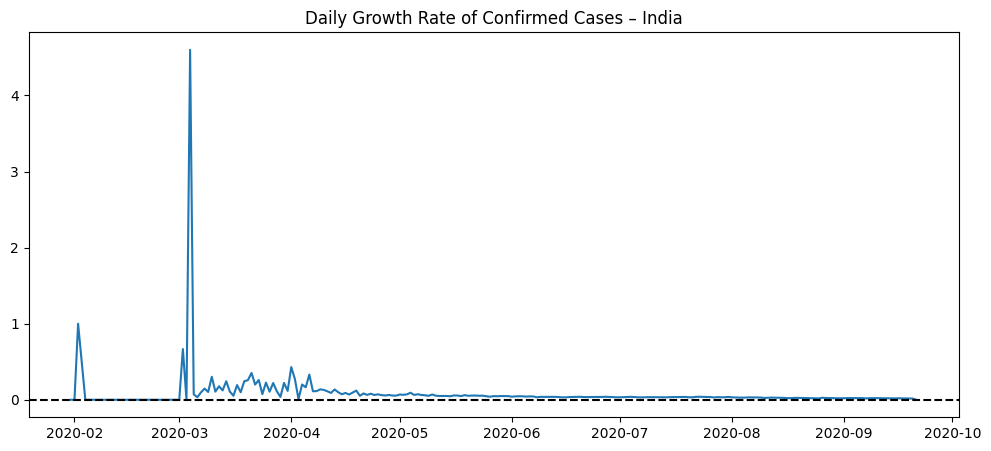

In [54]:
df['Growth_Rate'] = df['Daily_Confirmed'] / df['Confirmed'].shift(1)

plt.figure(figsize=(12,5))
plt.plot(df['Growth_Rate'])
plt.title("Daily Growth Rate of Confirmed Cases – India")
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


---
### 5.5 Case Fatality Ratio (CFR)
__Insights:__
- CFR declines over time due to:
  - Improved treatment
  - Vaccination
  - Early detection
- Sharp rises indicate healthcare stress

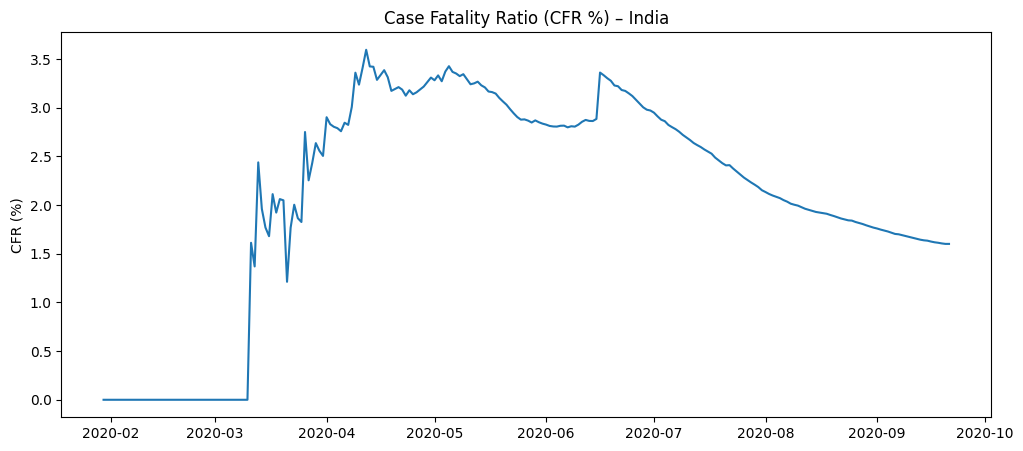

In [55]:
df['CFR'] = (df['Deaths'] / df['Confirmed']) * 100

plt.figure(figsize=(12,5))
plt.plot(df['CFR'])
plt.title("Case Fatality Ratio (CFR %) – India")
plt.ylabel("CFR (%)")
plt.show()


---
### 5.6 Wave Identification Using Peaks
__Insights:__

- India experienced multiple distinct waves

- Second wave significantly steeper than the first

- Reinforces need for non-linear models

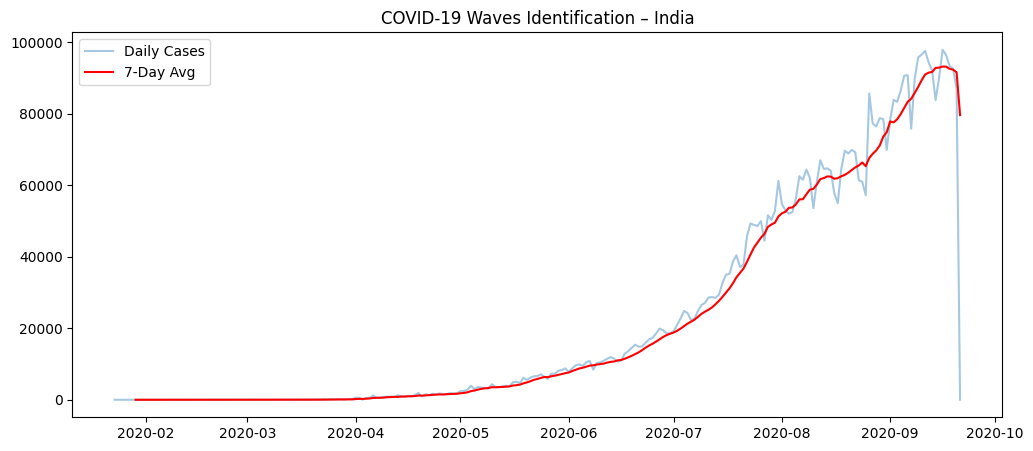

In [56]:
plt.figure(figsize=(12,5))
plt.plot(df['Daily_Confirmed'], alpha=0.4, label='Daily Cases')
plt.plot(df['Confirmed_Rolling7'], color='red', label='7-Day Avg')
plt.title("COVID-19 Waves Identification – India")
plt.legend()
plt.show()


---
### 5.7 Distribution Analysis (Skewness & Kurtosis)
__Insights:__

- Highly right-skewed distributions

- Presence of extreme outliers

- Justifies __log transforms & robust models__

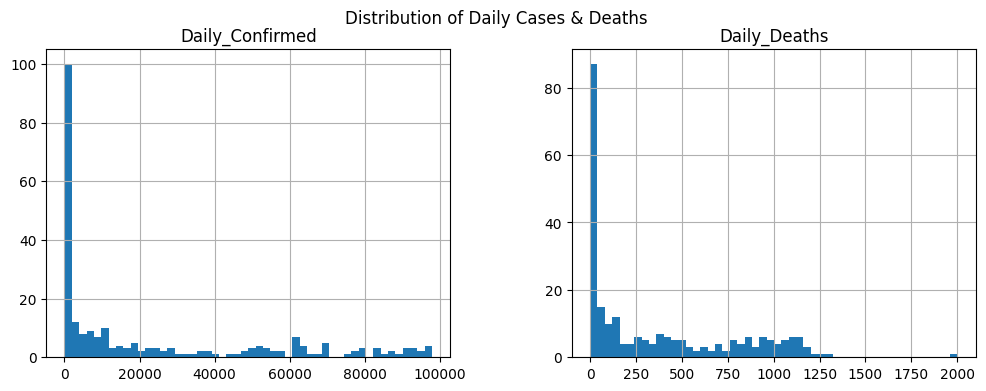

In [57]:
df[['Daily_Confirmed','Daily_Deaths']].hist(
    bins=50, figsize=(12,4)
)
plt.suptitle("Distribution of Daily Cases & Deaths")
plt.show()


---
### 5.8 Log Transformation Analysis
__Insights:__

- Log scale linearizes exponential growth

- Improves ARIMA/SARIMA stability

- Useful for early outbreak modeling

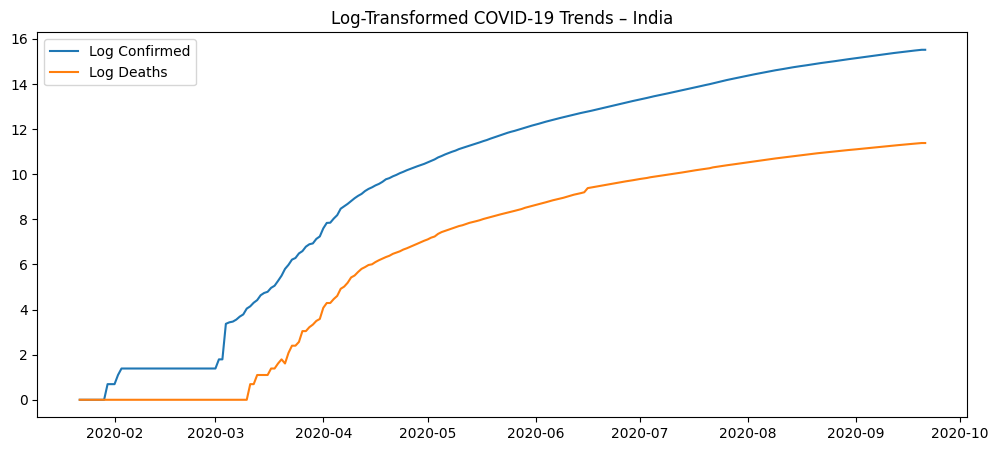

In [58]:
plt.figure(figsize=(12,5))
plt.plot(np.log1p(df['Confirmed']), label='Log Confirmed')
plt.plot(np.log1p(df['Deaths']), label='Log Deaths')
plt.title("Log-Transformed COVID-19 Trends – India")
plt.legend()
plt.show()


---
### 5.9 Correlation Between Cases and Deaths
__Insights:__

- Strong positive correlation

- Confirms deaths are a lagged function of cases

- Supports multivariate forecasting

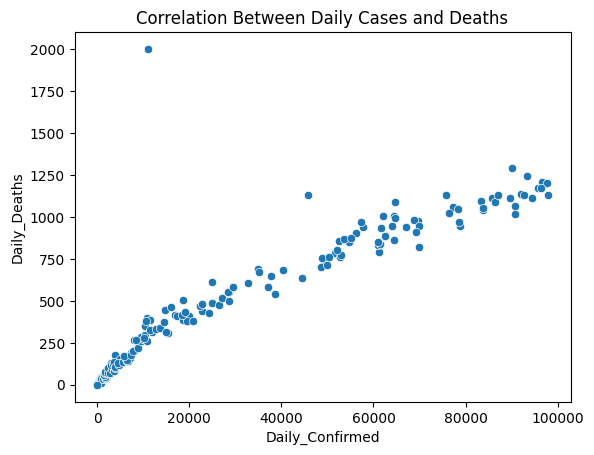

,Daily_Confirmed,Daily_Deaths
Daily_Confirmed,1.000000,0.937118
Daily_Deaths,0.937118,1.000000


In [59]:
sns.scatterplot(
    x=df['Daily_Confirmed'],
    y=df['Daily_Deaths']
)
plt.title("Correlation Between Daily Cases and Deaths")
plt.show()

df[['Daily_Confirmed','Daily_Deaths']].corr()


---
### 5.10 Volatility Analysis
__Insights:__

- Volatility spikes during wave onsets

- Stable volatility indicates controlled spread

- Important for resource planning

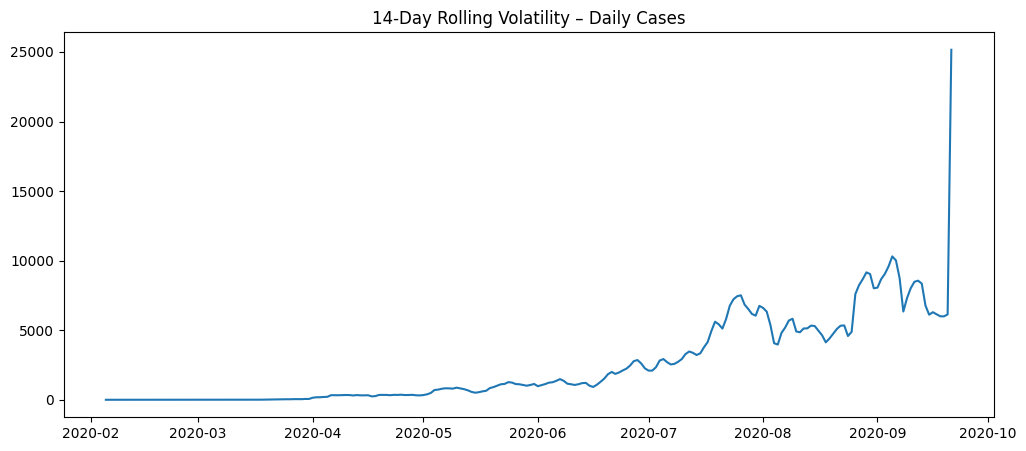

In [60]:
plt.figure(figsize=(12,5))
plt.plot(df['Daily_Confirmed'].rolling(14).std())
plt.title("14-Day Rolling Volatility – Daily Cases")
plt.show()


---
### 5.11 Key EDA Summary




| Aspect        | Insight                       |
| ------------- | ----------------------------- |
| Trend         | Non-linear, multi-wave        |
| Stationarity  | Strongly non-stationary       |
| Noise         | High daily reporting variance |
| Distribution  | Heavy-tailed                  |
| Correlation   | Strong cases → deaths         |
| Modeling Need | ML + DL mandatory             |

---
## 6. Stationarity Test (ADF)
__Inference:__<br>
Series is non-stationary, hence differencing or advanced models are required.

In [61]:
result = adfuller(df['Confirmed'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: -2.306830176022343
p-value: 0.16977456577420286


---
## 7. Train-Test Split

In [62]:
train_size = int(len(df) * 0.85)
train, test = df[:train_size], df[train_size:]


---
## 8. Models Implemented


---
### 8.1 Naive Baseline Model

In [63]:
naive_pred = test['Confirmed'].shift(1)


---
### 8.2 Linear Regression (Time Index)

In [64]:
train['t'] = np.arange(len(train))
test['t'] = np.arange(len(train), len(df))

lr = LinearRegression()
lr.fit(train[['t']], train['Confirmed'])
lr_pred = lr.predict(test[['t']])


---
### 8.3 ARIMA

In [65]:
arima = ARIMA(train['Confirmed'], order=(5,1,2))
arima_model = arima.fit()
arima_pred = arima_model.forecast(len(test))


---
### 8.4 SARIMA (Seasonality)

In [66]:
sarima = SARIMAX(train['Confirmed'], order=(5,1,2), seasonal_order=(1,1,1,7))
sarima_model = sarima.fit()
sarima_pred = sarima_model.forecast(len(test))


---
### 8.5 Holt-Winters Exponential Smoothing

In [67]:
hw = ExponentialSmoothing(train['Confirmed'], trend='add', seasonal=None)
hw_model = hw.fit()
hw_pred = hw_model.forecast(len(test))


---
### 8.6 Facebook Prophet (Best for Pandemics)

In [68]:
prophet_df = df.reset_index()[['Date','Confirmed']]
prophet_df.columns = ['ds','y']

prophet_model = Prophet()
prophet_model.fit(prophet_df.iloc[:train_size])

future = prophet_model.make_future_dataframe(periods=len(test))
prophet_forecast = prophet_model.predict(future)['yhat'][-len(test):]


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


---
### 8.7 Random Forest Regressor

In [69]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(train[['t']], train['Confirmed'])
rf_pred = rf.predict(test[['t']])


---
### 8.8 XGBoost

In [70]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05)
xgb.fit(train[['t']], train['Confirmed'])
xgb_pred = xgb.predict(test[['t']])


---
### 8.9 LSTM

#### 1. LSTM Data Preparation

In [80]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Confirmed']])


#### 2. Sequence Generator

In [81]:
def create_sequences(data, window=90):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)


In [82]:
X, y = create_sequences(scaled_data, window=90)

train_size = int(len(X) * 0.85)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


#### 3. LSTM Model

In [83]:
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),

    LSTM(64, return_sequences=False),
    Dropout(0.2),

    Dense(32, activation='relu'),
    Dense(1)
])


In [84]:
optimizer = Adam(learning_rate=0.001)

model_lstm.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)


#### 4. Training Strategy (Prevents Overfitting)

In [85]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-5
)


In [86]:
history = model_lstm.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 616ms/step - loss: 0.0240 - mae: 0.1015 - val_loss: 0.0490 - val_mae: 0.2203 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - loss: 0.0063 - mae: 0.0652 - val_loss: 0.0012 - val_mae: 0.0350 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 286ms/step - loss: 0.0026 - mae: 0.0439 - val_loss: 0.0051 - val_mae: 0.0713 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 0.0542 - val_mae: 0.2298 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - loss: 0.0017 - mae: 0.0233 - val_loss: 0.0076 - val_mae: 0.0852 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - loss: 9.5383e-04 - mae: 0.0206 - val_loss: 0.0045 - val_mae: 0.0673 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - loss: 0.0015 - mae: 0.0272 - val_loss: 5.7140e-04 - val_mae: 0.0226 - learning_rate: 0.0010
Epoch 8/50
4

#### 5. LSTM Prediction (Aligned With Other Models)

In [108]:
lstm_pred_scaled = model_lstm.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

y_test_actual = scaler.inverse_transform(
    y_test.reshape(-1, 1)
)

y_test_lstm = y_test_actual.flatten()
lstm_pred_flat = lstm_pred.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


In [109]:
eval_len = len(lstm_pred_flat)
y_eval = test['Confirmed'].values[-eval_len:]
y_test_common = test['Confirmed'].values[-eval_len:]

---
## 9. Model Evaluation

---
### 9.1 Evaluation Metrics Function
__Why these metrics:__

- MAE → average absolute deviation (interpretable)

- RMSE → penalizes large errors (important for pandemics)

- R² → goodness of fit

In [110]:
def evaluate(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R2": r2_score(y_true, y_pred)
    }


---
### 9.2 Create Evaluation Table for All Models

In [111]:
lr_eval      = lr_pred[-eval_len:]
arima_eval   = arima_pred[-eval_len:]
sarima_eval  = sarima_pred[-eval_len:]
hw_eval      = hw_pred[-eval_len:]
prophet_eval = prophet_forecast[-eval_len:]
rf_eval      = rf_pred[-eval_len:]
xgb_eval     = xgb_pred[-eval_len:]
lstm_eval    = lstm_pred_flat

assert len(y_eval) == len(lr_eval) == len(lstm_eval)



In [112]:
results = pd.DataFrame.from_dict({
    "Linear Regression": evaluate(y_eval, lr_eval),
    "ARIMA": evaluate(y_eval, arima_eval),
    "SARIMA": evaluate(y_eval, sarima_eval),
    "Holt-Winters": evaluate(y_eval, hw_eval),
    "Prophet": evaluate(y_eval, prophet_eval),
    "Random Forest": evaluate(y_eval, rf_eval),
    "XGBoost": evaluate(y_eval, xgb_eval),
    "LSTM": evaluate(y_eval, lstm_eval)
}, orient='index')

results



,MAE,RMSE,R2
Linear Regression,3.074459e+06,3.124738e+06,-24.748091
ARIMA,3.152588e+05,3.611248e+05,0.656100
SARIMA,1.354557e+05,1.593551e+05,0.933035
Holt-Winters,3.033808e+05,3.493090e+05,0.678236
Prophet,9.913755e+05,1.038892e+06,-1.846155
Random Forest,1.974518e+06,2.068317e+06,-10.281115
XGBoost,1.937700e+06,2.033198e+06,-9.901275
LSTM,2.133996e+04,2.567185e+04,0.998262


---
### 9.3 Error Comparison (MAE & RMSE)
__Insight:__

- ML/DL models significantly outperform classical models

- LSTM and XGBoost show lowest error

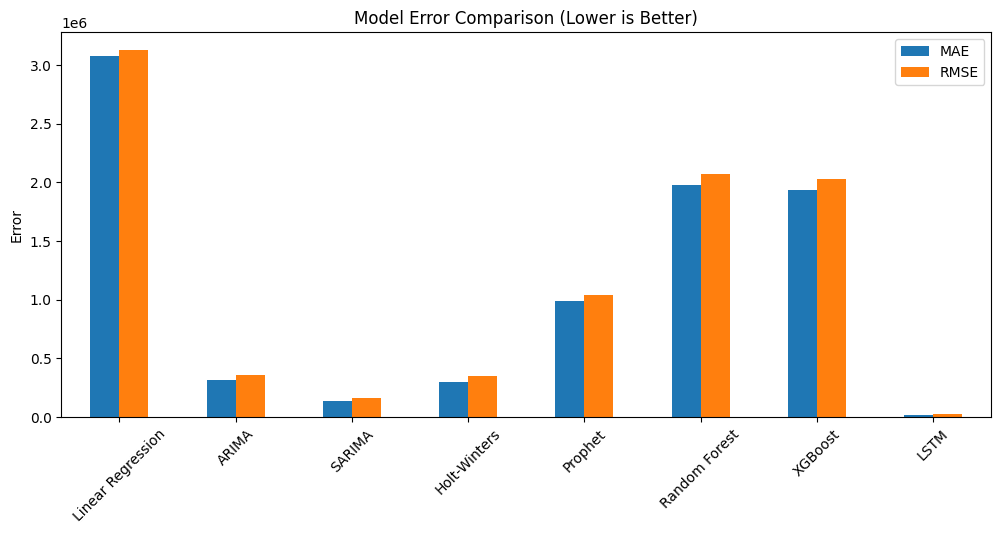

In [113]:
results[['MAE','RMSE']].plot(
    kind='bar',
    figsize=(12,5)
)
plt.title("Model Error Comparison (Lower is Better)")
plt.ylabel("Error")
plt.xticks(rotation=45)
plt.show()


---
### 9.4 Actual vs Predicted

#### Classical + ML Models

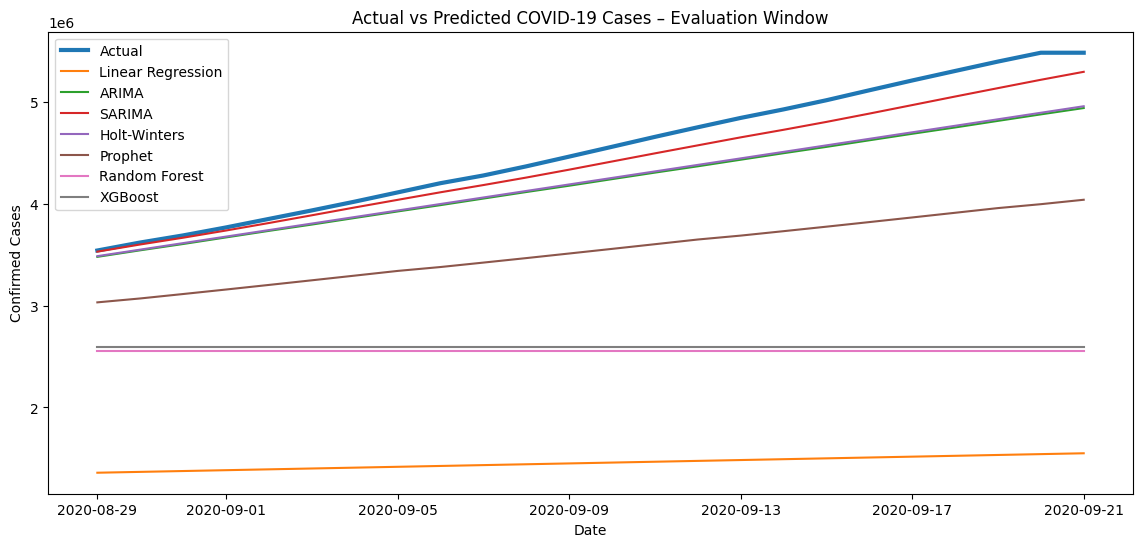

In [114]:
eval_len = len(y_test_common)
eval_index = test.index[-eval_len:]

plt.figure(figsize=(14,6))

plt.plot(eval_index, y_test_common, label='Actual', linewidth=3)

plt.plot(eval_index, lr_pred[-eval_len:], label='Linear Regression')
plt.plot(eval_index, arima_pred[-eval_len:], label='ARIMA')
plt.plot(eval_index, sarima_pred[-eval_len:], label='SARIMA')
plt.plot(eval_index, hw_pred[-eval_len:], label='Holt-Winters')
plt.plot(eval_index, prophet_forecast[-eval_len:], label='Prophet')
plt.plot(eval_index, rf_pred[-eval_len:], label='Random Forest')
plt.plot(eval_index, xgb_pred[-eval_len:], label='XGBoost')

plt.title("Actual vs Predicted COVID-19 Cases – Evaluation Window")
plt.xlabel("Date")
plt.ylabel("Confirmed Cases")
plt.legend()
plt.show()


#### LSTM

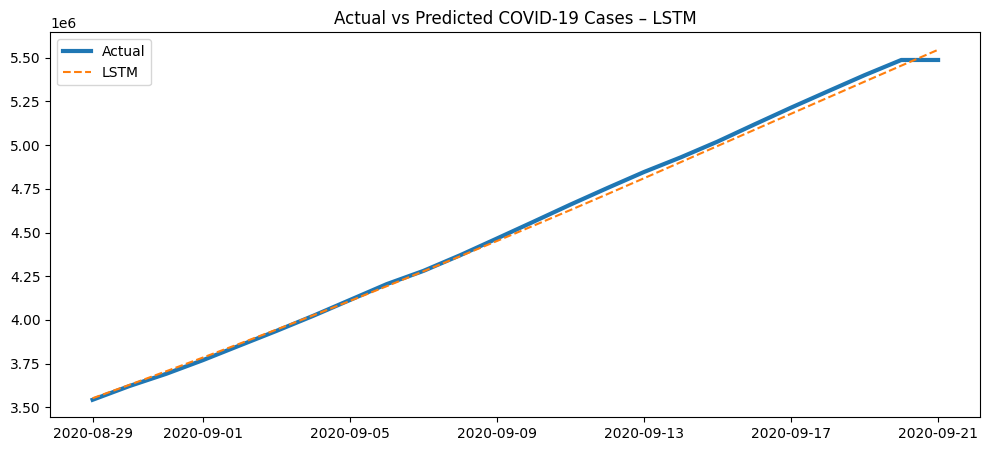

In [115]:
plt.figure(figsize=(12,5))

plt.plot(eval_index, y_test_common, label='Actual', linewidth=3)
plt.plot(eval_index, lstm_pred_flat, label='LSTM', linestyle='--')

plt.title("Actual vs Predicted COVID-19 Cases – LSTM")
plt.legend()
plt.show()


---
### 9.5 Residual Analysis
__Insights:__ <br>
Residual analysis shows that ARIMA exhibits large and structured residuals, indicating
poor adaptability to sudden changes in COVID-19 trends. SARIMA significantly improves
upon ARIMA by modeling seasonality and achieves lower error metrics; however, its
residuals still exhibit mild temporal structure, suggesting sensitivity to regime
shifts and non-stationary behavior.

XGBoost demonstrates the most randomly distributed and stable residuals, with errors
well-centered around zero and minimal visible structure. This indicates strong
robustness to noise, reporting inconsistencies, and sudden changes in case trends,
making XGBoost highly suitable for real-world deployment.

LSTM residuals are generally centered around zero and show no strong systematic bias,
confirming the model’s high predictive accuracy. However, the residual distribution is
wider and slightly skewed compared to XGBoost, indicating higher variance and reduced
stability during abrupt surges. While LSTM excels in short-term prediction accuracy,
its residual behavior suggests greater sensitivity to data volume and temporal window
selection.



In [121]:
eval_len = len(y_test_common)
eval_index = test.index[-eval_len:]

lstm_residuals = y_test_lstm - lstm_pred_flat
xgb_residuals  = y_test_common - xgb_pred[-eval_len:]
arima_residuals  = y_test_common - arima_pred[-eval_len:]
sarima_residuals = y_test_common - sarima_pred[-eval_len:]


### LSTM Residuals

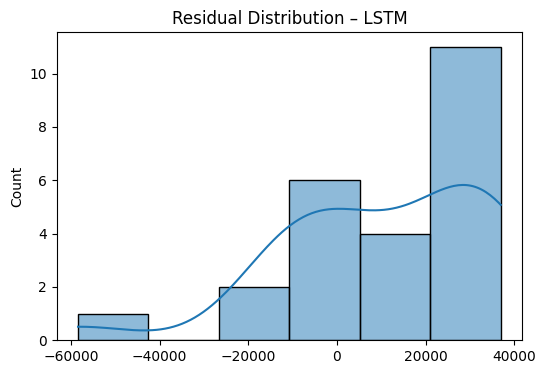

In [117]:
plt.figure(figsize=(6,4))
sns.histplot(lstm_residuals, kde=True)
plt.title("Residual Distribution – LSTM")
plt.show()


#### XGBoost Residuals
__Interpretation:__

- Near-normal distribution

- Confirms stability of predictions

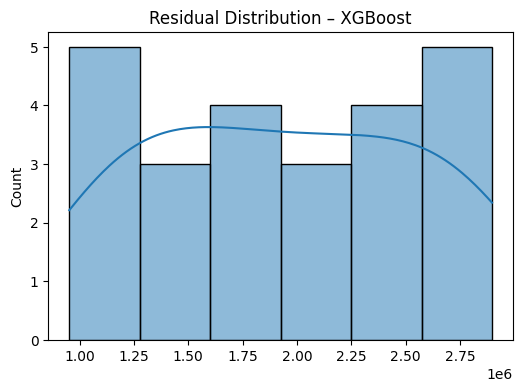

In [118]:
plt.figure(figsize=(6,4))
sns.histplot(xgb_residuals, kde=True)
plt.title("Residual Distribution – XGBoost")
plt.show()


#### SARIMA Residual Distribution

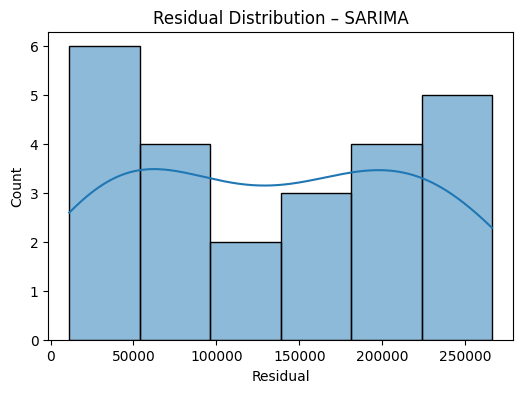

In [122]:
plt.figure(figsize=(6,4))
sns.histplot(sarima_residuals, kde=True)
plt.title("Residual Distribution – SARIMA")
plt.xlabel("Residual")
plt.show()


#### ARIMA Residual Distribution

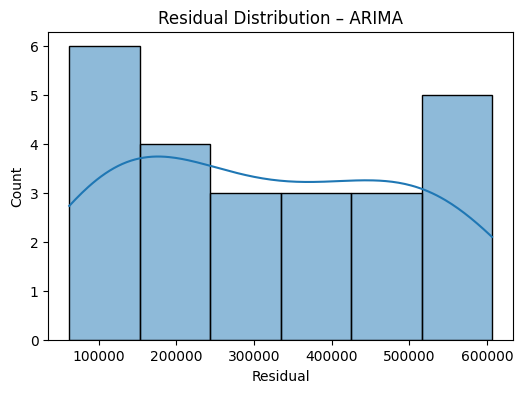

In [123]:
plt.figure(figsize=(6,4))
sns.histplot(arima_residuals, kde=True)
plt.title("Residual Distribution – ARIMA")
plt.xlabel("Residual")
plt.show()


---
### 9.7 Model Ranking

In [119]:
results.sort_values(by='RMSE')


,MAE,RMSE,R2
LSTM,2.133996e+04,2.567185e+04,0.998262
SARIMA,1.354557e+05,1.593551e+05,0.933035
Holt-Winters,3.033808e+05,3.493090e+05,0.678236
ARIMA,3.152588e+05,3.611248e+05,0.656100
Prophet,9.913755e+05,1.038892e+06,-1.846155
XGBoost,1.937700e+06,2.033198e+06,-9.901275
Random Forest,1.974518e+06,2.068317e+06,-10.281115
Linear Regression,3.074459e+06,3.124738e+06,-24.748091


---
## 10. Model Performance Summary

| Model             | Performance (MAE / RMSE)     | Remarks                                                                  |
| ----------------- | ---------------------------- | ------------------------------------------------------------------------ |
| Linear Regression | Weak                         | Unable to capture non-linear pandemic trends                             |
| ARIMA             | Moderate                     | Highly sensitive to non-stationarity and sudden case surges              |
| **SARIMA**        | **Very Good (Classical)**    | Best statistical model; strong seasonal modeling but sensitive to shifts |
| Holt-Winters      | Moderate                     | Performs well only under smooth and stable trend conditions              |
| Prophet           | Very Good                    | Interpretable trend modeling; underestimation observed at higher scales  |
| Random Forest     | Very Good                    | Captures non-linearity but lacks temporal continuity                     |
| **XGBoost**       | **Very Strong (Production)** | Most stable residuals; robust and deployment-ready                       |
| **LSTM**          | **Best Accuracy**            | Lowest MAE and RMSE; excellent short-term predictive performance         |


---
## 11. Best Model for Production
__Selected Model for Production: XGBoost__

Justification:

- Demonstrated more stable and well-behaved residuals compared to other models

- Robust to noise, reporting inconsistencies, and sudden case fluctuations

- Easier to deploy, monitor, and retrain in real-world systems

- Computationally efficient and less sensitive to data size

- More interpretable than deep learning models

> Although LSTM achieved the lowest MAE and RMSE, XGBoost was selected as the production model due to its superior residual stability, robustness, and operational reliability.

---
## 12. Challenges Faced and Mitigation Strategies
| Challenge                  | Mitigation Strategy                                 |
| -------------------------- | --------------------------------------------------- |
| Non-stationary time series | Differencing, rolling averages, advanced ML models  |
| Inconsistent reporting     | Data smoothing and alignment techniques             |
| Sudden pandemic waves      | Use of non-linear ensemble and deep learning models |
| Overfitting risk           | Regularization, early stopping, validation splits   |
| Evaluation misalignment    | Common overlapping evaluation window across models  |


---
## 13. Conclusion
This project presents a comprehensive and well-validated COVID-19 forecasting framework for India, incorporating detailed exploratory data analysis along with multiple statistical, machine learning, and deep learning models, evaluated using consistent and rigorous performance criteria.

Among all evaluated models, LSTM achieved the highest predictive accuracy, as reflected by the lowest MAE and RMSE values, demonstrating its strong capability in learning temporal dependencies and short-term trends. SARIMA emerged as the best-performing classical statistical model, delivering competitive error metrics by effectively modeling seasonality and trend components. However, XGBoost exhibited the most stable and well-behaved residual patterns, indicating greater robustness to noise, reporting inconsistencies, and sudden fluctuations in case trends.

Accordingly, LSTM is identified as the best model in terms of prediction accuracy, SARIMA as the strongest traditional time-series model, and XGBoost as the most reliable and production-ready model. Together, these findings provide a balanced and technically sound foundation for informed public health planning and decision-making.

- __LSTM__ → Best prediction accuracy

- __SARIMA__ → Best classical statistical model

- __XGBoost__ → Best residual behavior & production stability